## Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from rdkit import Chem
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, GINEConv


## Configuration

In [ ]:
DATA_CSV = r"C:\Users\kumar\Downloads\Training_data.csv" 
ROOT = "data_multitask_fixed/"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32
LR = 3e-4
WEIGHT_DECAY = 1e-4
EPOCHS = 500
PATIENCE = 25
HIDDEN_DIM = 256
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
os.makedirs(ROOT, exist_ok=True)

## Load & Clean Dataset (Multi-Target)

In [ ]:
df = pd.read_csv(DATA_CSV)
targets_cols = ["Pred DCN", "Pred MON", "Pred RON"]
df = df.dropna(subset=["SMILES"] + targets_cols)
df["SMILES"] = df["SMILES"].astype(str).str.strip()

smiles_list = df["SMILES"].tolist()
targets = df[targets_cols].to_numpy(dtype=float)

# Normalize targets
target_scaler = StandardScaler()
targets_norm = target_scaler.fit_transform(targets)

## Atom & Bond Features

In [ ]:
hyb_types = [
    Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2,
]

bond_type_map = {
    Chem.rdchem.BondType.SINGLE: 0,
    Chem.rdchem.BondType.DOUBLE: 1,
    Chem.rdchem.BondType.TRIPLE: 2,
    Chem.rdchem.BondType.AROMATIC: 3,
}

def atom_feature_list(atom):
    hyb_onehot = [int(atom.GetHybridization() == h) for h in hyb_types]
    return [
        atom.GetAtomicNum(),
        atom.GetTotalDegree(),
        atom.GetFormalCharge(),
        atom.GetTotalNumHs(includeNeighbors=True),
        int(atom.GetIsAromatic()),
        atom.GetImplicitValence(),
        atom.GetMass(),
        int(atom.IsInRing()),
    ] + hyb_onehot

def bond_feature_list(bond):
    bt_idx = bond_type_map.get(bond.GetBondType(), 0)
    bt_onehot = [0, 0, 0, 0]; bt_onehot[bt_idx] = 1
    return bt_onehot + [
        int(bond.GetIsConjugated()),
        int(bond.IsInRing()),
        int(bond.GetStereo() != Chem.rdchem.BondStereo.STEREONONE)
    ]


##  Preprocess SMILES → Graphs & Scale Node Features

In [ ]:
node_rows, temp_graphs, invalid_smiles = [], [], []
for smi, t in zip(smiles_list, targets_norm):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        invalid_smiles.append(smi)
        continue

    atoms = [atom_feature_list(a) for a in mol.GetAtoms()]
    for r in atoms:
        node_rows.append(r)

    bonds = []
    for b in mol.GetBonds():
        s, e = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        bonds.append((s, e, bond_feature_list(b)))

    temp_graphs.append((atoms, bonds, t, smi))

print(f" Removed {len(invalid_smiles)} invalid SMILES entries.")
scaler = StandardScaler().fit(np.array(node_rows, dtype=float))

## Build PyG Graphs

In [ ]:
data_list = []
for atoms, bonds, t, smi in temp_graphs:
    x = torch.tensor(scaler.transform(np.array(atoms, dtype=float)), dtype=torch.float)

    if len(bonds) == 0:
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.zeros((0, 7), dtype=torch.float)
    else:
        ei, ea = [], []
        for s, e, bf in bonds:
            ei.append([s, e]); ei.append([e, s])
            ea.append(bf); ea.append(bf)
        edge_index = torch.tensor(ei, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(ea, dtype=torch.float)

    y = torch.tensor(t, dtype=torch.float)
    data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y))

print(f" Valid molecules: {len(data_list)}")

##  Dataset Split

In [ ]:
class FuelDataset(InMemoryDataset):
    def __init__(self, data_list=None, root=ROOT, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        if data_list is not None:
            self.data, self.slices = self.collate(data_list)

dataset = FuelDataset(data_list=data_list)
n = len(dataset)
train_len = int(0.8 * n)
test_len = n - train_len
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, test_len])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
print(f"Data ready: {train_len} train / {test_len} test")

## GNN Model for Multi-Task Regression

In [ ]:
# 7. GNN Model for Multi-Task Regression

class GNNMultiTask(nn.Module):
    def __init__(self, node_dim, hidden_dim=HIDDEN_DIM, out_dim=3, dropout=0.2):
        super().__init__()
        self.input_lin = nn.Linear(node_dim, hidden_dim)
        self.conv1 = GINEConv(
            nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)),
            edge_dim=7)
        self.conv2 = GINEConv(
            nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)),
            edge_dim=7)
        self.lin1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.lin2 = nn.Linear(hidden_dim // 2, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(hidden_dim)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = F.relu(self.input_lin(x))
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_mean_pool(x, batch)
        x = self.bn(x)
        x = self.dropout(F.relu(self.lin1(x)))
        return self.lin2(x)

model = GNNMultiTask(node_dim=data_list[0].x.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.MSELoss()

## Train / Eval

In [ ]:
def train_epoch(loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(DEVICE)
        optimizer.zero_grad()
        pred = model(data)
        target = data.y.view(-1, 3)  # Fix target shape
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def eval_epoch(loader):
    model.eval()
    total_loss, preds, actuals = 0, [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(DEVICE)
            pred = model(data)
            target = data.y.view(-1, 3)  #  Fix target shape
            loss = criterion(pred, target)
            total_loss += loss.item() * data.num_graphs
            preds.append(pred.cpu().numpy())
            actuals.append(target.cpu().numpy())
    return total_loss / len(loader.dataset), np.vstack(preds), np.vstack(actuals)

## Training Loop


In [ ]:
best_r2 = -np.inf
patience_counter = 0
train_losses, test_losses = [], []
best_path = os.path.join(ROOT, "best_model.pt")

for epoch in range(1, EPOCHS + 1):
    tr_loss = train_epoch(train_loader)
    te_loss, preds, actuals = eval_epoch(test_loader)
    train_losses.append(tr_loss)
    test_losses.append(te_loss)

    preds_den = target_scaler.inverse_transform(preds)
    actuals_den = target_scaler.inverse_transform(actuals)
    r2s = [r2_score(actuals_den[:, i], preds_den[:, i]) for i in range(3)]
    mean_r2 = np.mean(r2s)

    if mean_r2 > best_r2:
        best_r2 = mean_r2
        patience_counter = 0
        torch.save(model.state_dict(), best_path)
    else:
        patience_counter += 1

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Train {tr_loss:.4f} | Test {te_loss:.4f} | R²={r2s} | MeanR²={mean_r2:.3f}")

    if patience_counter >= PATIENCE:
        print(f"Early stopping at epoch {epoch}, best MeanR²={best_r2:.3f}")
        break

model.load_state_dict(torch.load(best_path))
print(f" Loaded best model, MeanR²={best_r2:.3f}")

## Final Evaluation & Plots

 Removed 0 invalid SMILES entries.
 Valid molecules: 430
Data ready: 344 train / 86 test
Epoch 001 | Train 0.8407 | Test 0.7685 | R²=[0.05448232367268402, 0.05040613408255634, 0.05683353634062149] | MeanR²=0.054
Epoch 010 | Train 0.2382 | Test 0.2818 | R²=[0.60957402181262, 0.6432319856006377, 0.6993358933801462] | MeanR²=0.651
Epoch 020 | Train 0.2046 | Test 0.3990 | R²=[0.5025476155815267, 0.49185868765641916, 0.5306970236303292] | MeanR²=0.508
Epoch 030 | Train 0.1057 | Test 0.1025 | R²=[0.8119061852929326, 0.8913150626373748, 0.9081034538495079] | MeanR²=0.870
Epoch 040 | Train 0.1592 | Test 0.1156 | R²=[0.8366727098579488, 0.8538529204322295, 0.8791354281934484] | MeanR²=0.857
Epoch 050 | Train 0.1062 | Test 0.1036 | R²=[0.8313825735532279, 0.8808544490667246, 0.8984845523229016] | MeanR²=0.870
Epoch 060 | Train 0.0874 | Test 0.0632 | R²=[0.9179495326360435, 0.9209273200341064, 0.9270955908349253] | MeanR²=0.922
Epoch 070 | Train 0.1393 | Test 0.0882 | R²=[0.853250783106639, 0.899

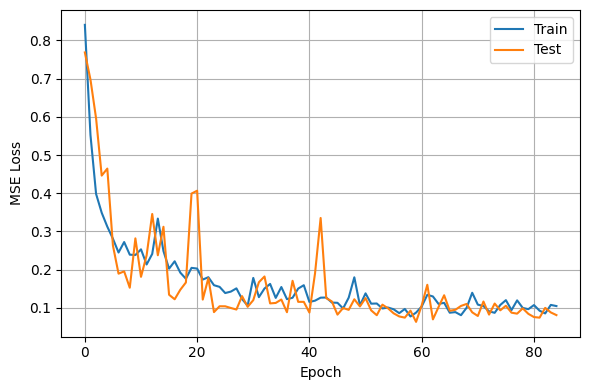

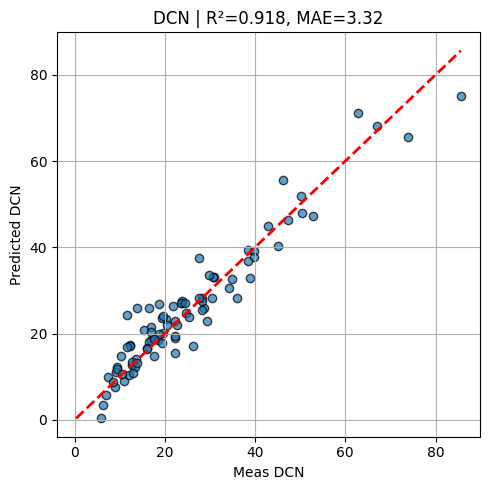

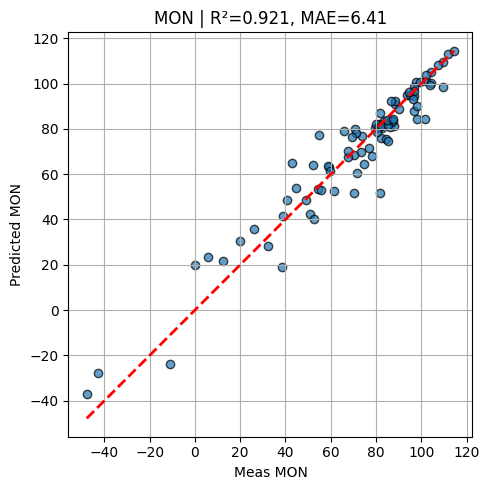

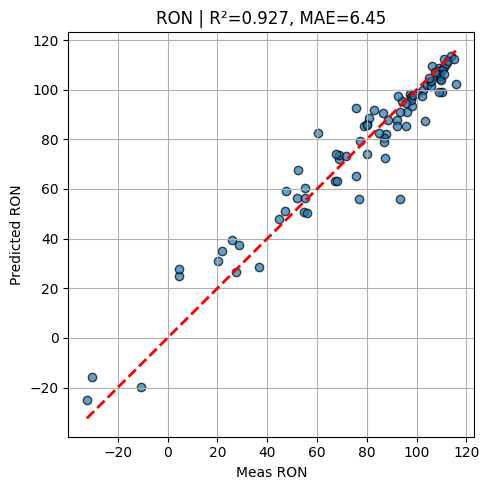

In [3]:
_, preds, actuals = eval_epoch(test_loader)
preds_den = target_scaler.inverse_transform(preds)
actuals_den = target_scaler.inverse_transform(actuals)
r2s = [r2_score(actuals_den[:, i], preds_den[:, i]) for i in range(3)]
maes = [mean_absolute_error(actuals_den[:, i], preds_den[:, i]) for i in range(3)]
print(f"\nFinal R² (DCN, MON, RON): {r2s}\nFinal MAE: {maes}")

# --- Loss curves ---
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# --- Parity plots ---
cols = ["DCN", "MON", "RON"]
for i in range(3):
    plt.figure(figsize=(5, 5))
    plt.scatter(actuals_den[:, i], preds_den[:, i], alpha=0.7, edgecolors='k')
    mn, mx = min(actuals_den[:, i].min(), preds_den[:, i].min()), max(actuals_den[:, i].max(), preds_den[:, i].max())
    plt.plot([mn, mx], [mn, mx], 'r--', lw=2)
    plt.xlabel(f"Meas {cols[i]}"); plt.ylabel(f"Predicted {cols[i]}")
    plt.title(f"{cols[i]} | R²={r2s[i]:.3f}, MAE={maes[i]:.2f}")
    plt.grid(True); plt.tight_layout(); plt.show()
